In [19]:
%pip install pulp
%pip install pandas
%pip install openpyxl

In [ ]:
import pandas as pd
import numpy as np
import random
from pulp import *

In [36]:
df = pd.read_excel("data_for_the_case.xlsx", engine="openpyxl")
df.head()

,Course Code,Course Name,Credits,Trimester,Min Nb Groups,Max Nb Groups,Faculty 1,Faculty 2,Faculty 3,Faculty 4,Faculty 5,Faculty 6,Faculty 7,Faculty 8,Faculty 9,Faculty 10,Faculty 11,Faculty 12
0,T101,Operations Management,3,1,1,1,0,5,2,0,5,4,3,0,3,5,2,2
1,T102,Data-Driven Decision Making,2,1,1,3,1,5,4,5,5,1,4,0,0,5,0,5
2,T103,Service Operations,2,1,1,1,1,0,4,1,3,0,3,1,3,4,2,5
3,T104,Project Management,2,1,2,2,2,2,0,0,1,4,0,5,2,1,1,5
4,T105,Simulation and System Dynamics,2,1,3,3,4,3,0,4,3,1,0,0,2,5,1,0


In [37]:
courses = df["Course Code"].tolist()
faculties = [f"Faculty {i}" for i in range(1, 13)]
preferences = {row["Course Code"]: row.iloc[6:].tolist() for _, row in df.iterrows()}
credits = {row["Course Code"]: row["Credits"] for _, row in df.iterrows()}
mins = {row["Course Code"]: row["Min Nb Groups"] for _, row in df.iterrows()}
maxs = {row["Course Code"]: row["Max Nb Groups"] for _, row in df.iterrows()}

print(courses)
print(faculties)
print(preferences)
print(credits)
print(mins)
print(maxs)

['T101', 'T102', 'T103', 'T104', 'T105', 'T106', 'T107', 'T108', 'T109', 'T110', 'T111', 'T112', 'T113', 'T114', 'T201', 'T202', 'T203', 'T204', 'T205', 'T206', 'T207', 'T208', 'T209', 'T210', 'T211', 'T212', 'T213', 'T214', 'T301', 'T302', 'T303', 'T304', 'T305', 'T306', 'T307', 'T308', 'T309', 'T310', 'T311', 'T312', 'T313', 'T314']
['Faculty 1', 'Faculty 2', 'Faculty 3', 'Faculty 4', 'Faculty 5', 'Faculty 6', 'Faculty 7', 'Faculty 8', 'Faculty 9', 'Faculty 10', 'Faculty 11', 'Faculty 12']
{'T101': [0, 5, 2, 0, 5, 4, 3, 0, 3, 5, 2, 2], 'T102': [1, 5, 4, 5, 5, 1, 4, 0, 0, 5, 0, 5], 'T103': [1, 0, 4, 1, 3, 0, 3, 1, 3, 4, 2, 5], 'T104': [2, 2, 0, 0, 1, 4, 0, 5, 2, 1, 1, 5], 'T105': [4, 3, 0, 4, 3, 1, 0, 0, 2, 5, 1, 0], 'T106': [1, 2, 0, 4, 2, 2, 0, 5, 3, 0, 2, 0], 'T107': [5, 3, 1, 2, 3, 4, 2, 3, 2, 0, 5, 5], 'T108': [1, 5, 4, 5, 2, 0, 1, 0, 3, 0, 1, 2], 'T109': [0, 4, 0, 5, 2, 2, 4, 2, 4, 5, 5, 4], 'T110': [4, 5, 0, 3, 4, 2, 3, 0, 0, 2, 4, 3], 'T111': [4, 1, 5, 2, 5, 0, 4, 4, 5, 0, 3, 

In [22]:
def get_semester(course_code):
    if course_code.startswith("T1"):
        return 1
    elif course_code.startswith("T2"):
        return 2
    else:
        return 3

semesters = {c: get_semester(c) for c in courses}

In [23]:
satis = LpProblem('satis', LpMaximize)

# variable x_{c,f,g} = if the gth of course c is taught by faculty f
groups = {c: range(mins[c], maxs[c] + 1) for c in courses}
x = LpVariable.dicts('x',  [(c, f, g) for c in courses for f in faculties for g in groups[c]], cat=LpBinary)

satis += lpSum(preferences[c][i] * x[(c, faculties[i], g)] for c in courses for i in range(len(faculties)) for g in groups[c])

# the number of groups for each course should btwn Min Nb Groups and Max Nb Groups
for c in courses:
    satis += lpSum(x[(c, f, g)] for f in faculties for g in groups[c]) >= mins[c]
    satis += lpSum(x[(c, f, g)] for f in faculties for g in groups[c]) <= maxs[c]


# the total workload of each faculty for each trimester should limit to 6 credits
for i, f in enumerate(faculties):
    for sem in range(1, 4):
        satis += lpSum(credits[c] * x[(c, f, g)] for c in courses if semesters[c] == sem for g in groups[c]) <= 6

# the total workload of each faculty for the whole academic year should btwn 10 and 16 credits
for i, f in enumerate(faculties):
    total_credits = lpSum(credits[c] * x[(c, f, g)] for c in courses for g in groups[c])
    satis += total_credits >= 10
    satis += total_credits <= 16

# the preference of each course for each faculty should not equal to 0
for c in courses:
    for i, f in enumerate(faculties):
        if preferences[c][i] == 0:
            for g in groups[c]:
                satis += x[(c, f, g)] == 0

satis.solve()

allocation = {(c, f, g): x[(c, f, g)].varValue for c in courses for f in faculties for g in groups[c] if x[(c, f, g)].varValue == 1}
# print("Optimal Course Allocation:", allocation)
print(allocation)
print("Solver Status:", LpStatus[satis.status])
print(pulp.value(satis.objective))


def calculate_faculty_credits_per_semester():
    faculty_semester_credits = {f: {sem: 0 for sem in range(1, 4)} for f in faculties}
    for (c, f, g), value in x.items():
        if value.varValue == 1:
            sem = semesters[c]
            faculty_semester_credits[f][sem] += credits[c]
    return faculty_semester_credits

def calculate_faculty_total_credits():
    faculty_total_credits = {f: 0 for f in faculties}
    for (c, f, g), value in x.items():
        if value.varValue == 1:
            faculty_total_credits[f] += credits[c]
    return faculty_total_credits

def calculate_course_allocations():
    course_allocations = {}
    for (c, f, g), value in x.items():
        if value.varValue == 1:
            if c not in course_allocations:
                course_allocations[c] = []
            course_allocations[c].append((f, g))

    cleaned_course_allocations = {}
    for course, assignments in course_allocations.items():
        new_assignments = []
        for new_g, (faculty, _) in enumerate(assignments, start=1):
            new_assignments.append((faculty, new_g))
        cleaned_course_allocations[course] = new_assignments

    return cleaned_course_allocations

faculty_semester_credits = calculate_faculty_credits_per_semester()
faculty_total_credits = calculate_faculty_total_credits()
course_allocations = calculate_course_allocations()

print("Each Faculty's Credits Per Semester:", faculty_semester_credits)
print("Each Faculty's Total Yearly Credits:", faculty_total_credits)
print("Course Allocations:", course_allocations)


{('T101', 'Faculty 6', 1): 1.0, ('T102', 'Faculty 5', 1): 1.0, ('T102', 'Faculty 5', 3): 1.0, ('T102', 'Faculty 10', 1): 1.0, ('T103', 'Faculty 12', 1): 1.0, ('T104', 'Faculty 8', 2): 1.0, ('T104', 'Faculty 12', 2): 1.0, ('T105', 'Faculty 1', 3): 1.0, ('T105', 'Faculty 4', 3): 1.0, ('T105', 'Faculty 10', 3): 1.0, ('T106', 'Faculty 8', 1): 1.0, ('T107', 'Faculty 11', 1): 1.0, ('T108', 'Faculty 2', 1): 1.0, ('T109', 'Faculty 10', 2): 1.0, ('T109', 'Faculty 11', 2): 1.0, ('T109', 'Faculty 11', 3): 1.0, ('T110', 'Faculty 2', 1): 1.0, ('T111', 'Faculty 3', 1): 1.0, ('T112', 'Faculty 1', 3): 1.0, ('T112', 'Faculty 4', 2): 1.0, ('T112', 'Faculty 4', 3): 1.0, ('T113', 'Faculty 5', 1): 1.0, ('T114', 'Faculty 7', 1): 1.0, ('T201', 'Faculty 1', 1): 1.0, ('T202', 'Faculty 7', 1): 1.0, ('T203', 'Faculty 2', 3): 1.0, ('T203', 'Faculty 11', 1): 1.0, ('T203', 'Faculty 11', 3): 1.0, ('T204', 'Faculty 6', 1): 1.0, ('T205', 'Faculty 12', 1): 1.0, ('T206', 'Faculty 3', 2): 1.0, ('T206', 'Faculty 6', 2): 1

In [24]:
for i in faculty_semester_credits:
    print(i, faculty_semester_credits[i])

Faculty 1 {1: 4, 2: 6, 3: 4}
Faculty 2 {1: 4, 2: 5, 3: 6}
Faculty 3 {1: 3, 2: 5, 3: 6}
Faculty 4 {1: 6, 2: 0, 3: 6}
Faculty 5 {1: 6, 2: 3, 3: 2}
Faculty 6 {1: 3, 2: 5, 3: 6}
Faculty 7 {1: 2, 2: 6, 3: 2}
Faculty 8 {1: 5, 2: 5, 3: 6}
Faculty 9 {1: 0, 2: 6, 3: 6}
Faculty 10 {1: 6, 2: 6, 3: 4}
Faculty 11 {1: 6, 2: 6, 3: 2}
Faculty 12 {1: 4, 2: 5, 3: 6}


In [25]:
for i in faculty_total_credits:
    print(i, faculty_total_credits[i])

Faculty 1 14
Faculty 2 15
Faculty 3 14
Faculty 4 12
Faculty 5 11
Faculty 6 14
Faculty 7 10
Faculty 8 16
Faculty 9 12
Faculty 10 16
Faculty 11 14
Faculty 12 15


In [26]:
course_allocations = calculate_course_allocations()

for course, assigned in course_allocations.items():
    print(course, assigned)

T101 [('Faculty 6', 1)]
T102 [('Faculty 5', 1), ('Faculty 5', 2), ('Faculty 10', 3)]
T103 [('Faculty 12', 1)]
T104 [('Faculty 8', 1), ('Faculty 12', 2)]
T105 [('Faculty 1', 1), ('Faculty 4', 2), ('Faculty 10', 3)]
T106 [('Faculty 8', 1)]
T107 [('Faculty 11', 1)]
T108 [('Faculty 2', 1)]
T109 [('Faculty 10', 1), ('Faculty 11', 2), ('Faculty 11', 3)]
T110 [('Faculty 2', 1)]
T111 [('Faculty 3', 1)]
T112 [('Faculty 1', 1), ('Faculty 4', 2), ('Faculty 4', 3)]
T113 [('Faculty 5', 1)]
T114 [('Faculty 7', 1)]
T201 [('Faculty 1', 1)]
T202 [('Faculty 7', 1)]
T203 [('Faculty 2', 1), ('Faculty 11', 2), ('Faculty 11', 3)]
T204 [('Faculty 6', 1)]
T205 [('Faculty 12', 1)]
T206 [('Faculty 3', 1), ('Faculty 6', 2)]
T207 [('Faculty 3', 1), ('Faculty 5', 2), ('Faculty 8', 3)]
T208 [('Faculty 9', 1)]
T209 [('Faculty 7', 1)]
T210 [('Faculty 2', 1), ('Faculty 8', 2)]
T211 [('Faculty 1', 1), ('Faculty 1', 2)]
T212 [('Faculty 10', 1)]
T213 [('Faculty 9', 1), ('Faculty 12', 2)]
T214 [('Faculty 10', 1)]
T301 [('

In [ ]:
%pip install tqdm

T101 [('Faculty 6', 1), ('Faculty 6', 2)]
T102 [('Faculty 5', 1), ('Faculty 10', 2)]
T103 [('Faculty 3', 1), ('Faculty 12', 2)]
T104 [('Faculty 12', 1), ('Faculty 12', 2)]
T105 [('Faculty 10', 1), ('Faculty 10', 2)]
T106 [('Faculty 8', 1), ('Faculty 8', 2)]
T107 [('Faculty 1', 1), ('Faculty 11', 2)]
T108 [('Faculty 2', 1), ('Faculty 4', 2)]
T109 [('Faculty 11', 1), ('Faculty 11', 2)]
T110 [('Faculty 1', 1), ('Faculty 2', 2)]
T111 [('Faculty 3', 1), ('Faculty 9', 2)]
T112 [('Faculty 4', 1), ('Faculty 4', 2)]
T113 [('Faculty 5', 1), ('Faculty 5', 2)]
T114 [('Faculty 7', 1), ('Faculty 7', 2)]
T201 [('Faculty 1', 1), ('Faculty 12', 2)]
T202 [('Faculty 2', 1), ('Faculty 2', 2)]
T203 [('Faculty 11', 1), ('Faculty 11', 2)]
T204 [('Faculty 6', 1), ('Faculty 6', 2)]
T205 [('Faculty 12', 1), ('Faculty 12', 2)]
T206 [('Faculty 3', 1), ('Faculty 8', 2)]
T207 [('Faculty 5', 1), ('Faculty 5', 2)]
T208 [('Faculty 9', 1), ('Faculty 9', 2)]
T209 [('Faculty 7', 1), ('Faculty 7', 2)]
T210 [('Faculty 8', 

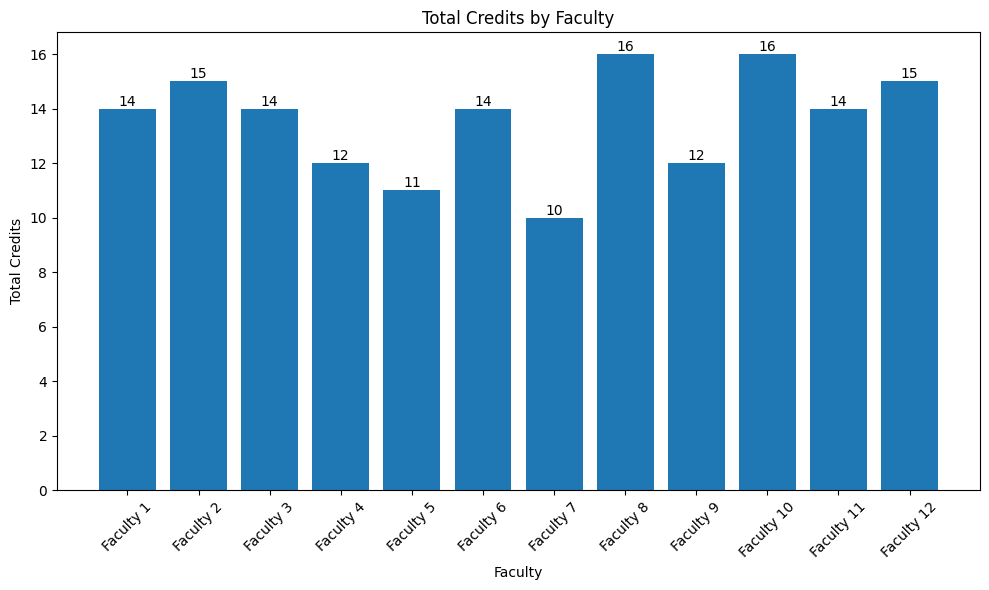

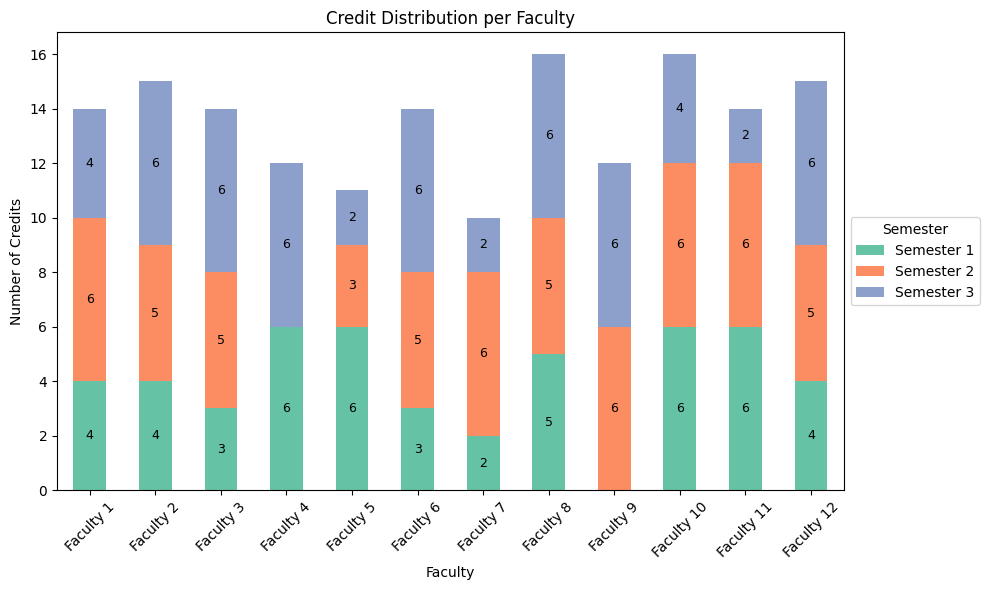

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, LpStatus, value
from scipy.stats import pearsonr
import pandas as pd

student_fixed = 50
group_size = 20
group_size_min = 20
group_size_max = 60

courses = df["Course Code"].tolist()
faculties = [f"Faculty {i}" for i in range(1, 13)]
preferences = {row["Course Code"]: row.iloc[6:].tolist() for _, row in df.iterrows()}
credits = {row["Course Code"]: row["Credits"] for _, row in df.iterrows()}
semesters = {row["Course Code"]: row["Trimester"] for _, row in df.iterrows()}

students = {c: student_fixed for c in courses}
mins = {c: (students[c] // group_size_max) + 1 for c in courses}
maxs = {c: (students[c] // group_size_min) for c in courses}
groups = {c: range(mins[c], maxs[c] + 1) for c in courses}

model = LpProblem('CourseAllocation', LpMaximize)
x = LpVariable.dicts('x', [(c, f, g) for c in courses for f in faculties for g in groups[c]], cat='Binary')

model += lpSum(preferences[c][i] * x[(c, faculties[i], g)]
                for c in courses for i in range(len(faculties)) for g in groups[c])

for c in courses:
    model += lpSum(x[(c, f, g)] for f in faculties for g in groups[c]) >= mins[c]
    model += lpSum(x[(c, f, g)] for f in faculties for g in groups[c]) <= maxs[c]

for f in faculties:
    for sem in range(1, 4):
        model += lpSum(credits[c] * x[(c, f, g)] for c in courses if semesters[c] == sem for g in groups[c]) <= 6

for f in faculties:
    total = lpSum(credits[c] * x[(c, f, g)] for c in courses for g in groups[c])
    model += total >= 10
    model += total <= 16

for c in courses:
    for i, f in enumerate(faculties):
        if preferences[c][i] == 0:
            for g in groups[c]:
                model += x[(c, f, g)] == 0

model.solve()

allocation = {(c, f, g): x[(c, f, g)].varValue for c in courses for f in faculties for g in groups[c] if x[(c, f, g)].varValue == 1}
course_allocations = calculate_course_allocations()

for course, assigned in course_allocations.items():
    print(course, assigned)
print("The optimal value of total happiness is", pulp.value(model.objective))



import matplotlib.pyplot as plt

# Data
faculties = [
    "Faculty 1", "Faculty 2", "Faculty 3", "Faculty 4", "Faculty 5",
    "Faculty 6", "Faculty 7", "Faculty 8", "Faculty 9", "Faculty 10",
    "Faculty 11", "Faculty 12"
]
credits = [14, 15, 14, 12, 11, 14, 10, 16, 12, 16, 14, 15]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(faculties, credits)

# Add numbers on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             str(bar.get_height()), ha='center', va='bottom')

# Labels and title
plt.title("Total Credits by Faculty")
plt.xlabel("Faculty")
plt.ylabel("Total Credits")
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import pandas as pd

# Credit distribution by semester
category_distribution = {
    'Faculty 1': {1: 4, 2: 6, 3: 4},  'Faculty 2': {1: 4, 2: 5, 3: 6},
    'Faculty 3': {1: 3, 2: 5, 3: 6},  'Faculty 4': {1: 6, 2: 0, 3: 6},
    'Faculty 5': {1: 6, 2: 3, 3: 2},  'Faculty 6': {1: 3, 2: 5, 3: 6},
    'Faculty 7': {1: 2, 2: 6, 3: 2},  'Faculty 8': {1: 5, 2: 5, 3: 6},
    'Faculty 9': {1: 0, 2: 6, 3: 6},  'Faculty 10': {1: 6, 2: 6, 3: 4},
    'Faculty 11': {1: 6, 2: 6, 3: 2}, 'Faculty 12': {1: 4, 2: 5, 3: 6}
}

# Convert to DataFrame
df = pd.DataFrame(category_distribution).T
df.columns = ['Semester 1', 'Semester 2', 'Semester 3']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.get_cmap('Set2').colors
bars = df.plot(kind='bar', stacked=True, color=colors, ax=ax)

# Add data labels
for i, faculty in enumerate(df.index):
    bottom = 0
    for j, semester in enumerate(df.columns):
        value = df.loc[faculty, semester]
        if value > 0:
            ax.text(i, bottom + value / 2, str(value), ha='center', va='center', fontsize=9)
        bottom += value

# Style
plt.title('Credit Distribution per Faculty')
plt.ylabel('Number of Credits')
plt.xlabel('Faculty')
plt.xticks(rotation=45)
plt.legend(title='Semester', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()

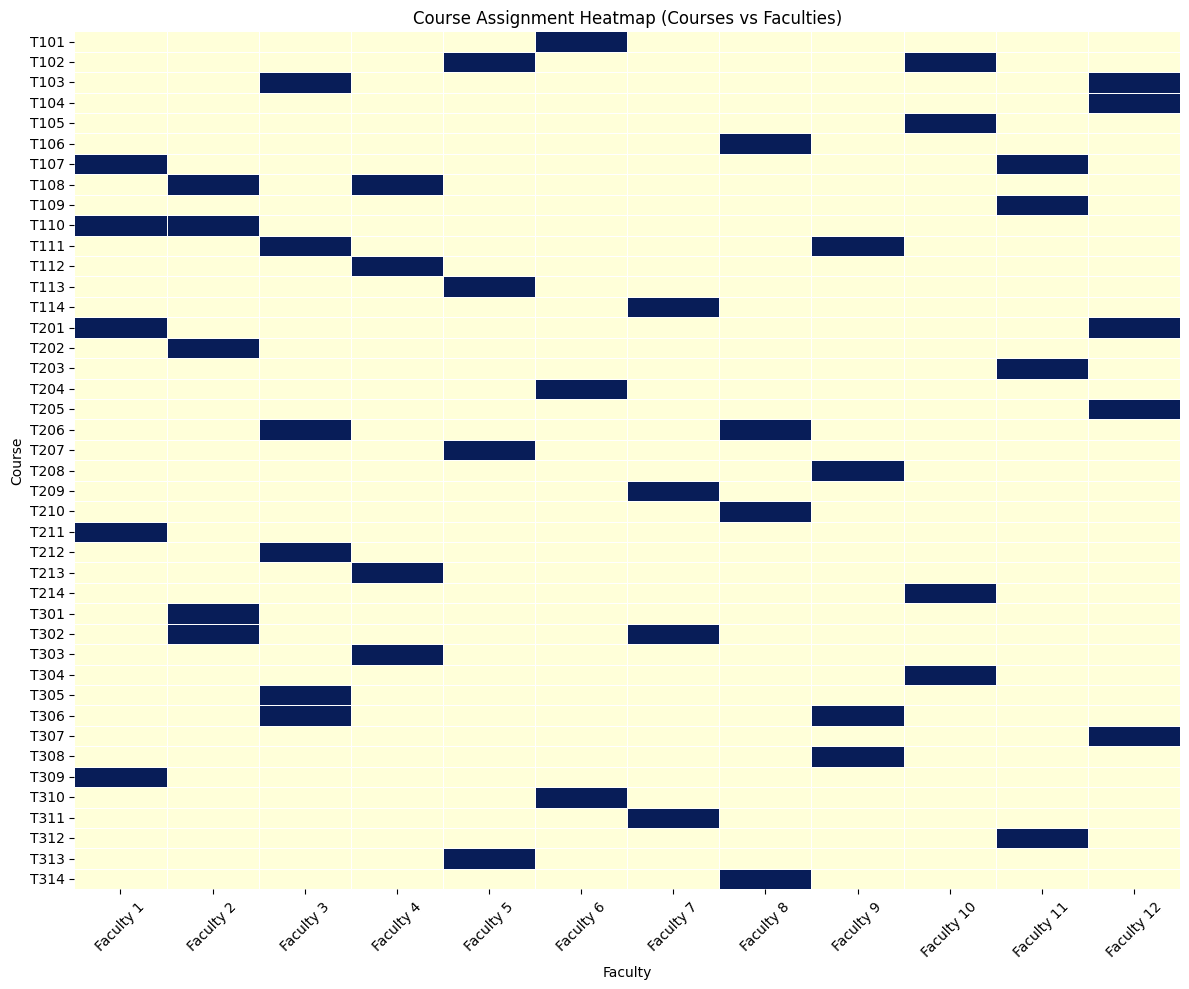

In [39]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Create a course × faculty assignment matrix
assignment_matrix = pd.DataFrame(0, index=courses, columns=faculties)

# Accumulate assignment results across all semesters
for (c, f, t) in x:
    if x[(c, f, t)].varValue == 1:
        assignment_matrix.loc[c, f] = 1  # Set to 1 if assigned

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(assignment_matrix, cmap="YlGnBu", linewidths=0.5, cbar=False)
plt.title("Course Assignment Heatmap (Courses vs Faculties)")
plt.ylabel("Course")
plt.xlabel("Faculty")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

100%|██████████| 1000/1000 [05:09<00:00,  3.23it/s]


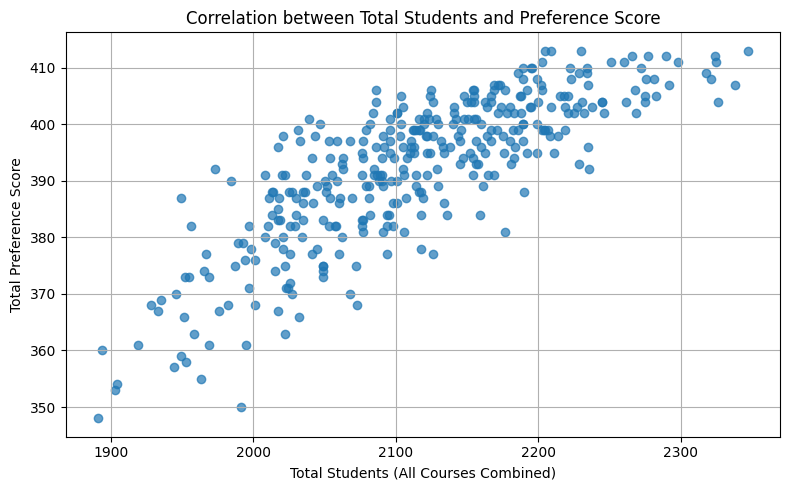

📊 Pearson correlation r = 0.8103 (p = 0.0000)
There is a significant linear correlation between changes in student population and preference scores！


In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, LpStatus, value
from scipy.stats import pearsonr

student_mean = 50
student_std = 15
group_size_min = 20
group_size_max = 60
simulations = 1000
objective_values = []
total_students_list = []
semester_group_counts = []

baseline_score = 396
greater_count = 0
infeasible_count = 0

courses = df["Course Code"].tolist()
faculties = [f"Faculty {i}" for i in range(1, 13)]
preferences = {row["Course Code"]: row.iloc[6:].tolist() for _, row in df.iterrows()}
credits = {row["Course Code"]: row["Credits"] for _, row in df.iterrows()}
semesters = {row["Course Code"]: row["Trimester"] for _, row in df.iterrows()}

for sim in tqdm(range(simulations)):
    students = {c: max(10, int(np.random.normal(student_mean, student_std))) for c in courses}
    total_students = sum(students.values())
    mins = {c: (students[c] // group_size_max) + 1 for c in courses}
    maxs = {c: (students[c] // group_size_min) for c in courses}
    groups = {c: range(mins[c], maxs[c] + 1) for c in courses}

    model = LpProblem('CourseAllocation', LpMaximize)
    x = LpVariable.dicts('x', [(c, f, g) for c in courses for f in faculties for g in groups[c]], cat='Binary')

    model += lpSum(preferences[c][i] * x[(c, faculties[i], g)]
                   for c in courses for i in range(len(faculties)) for g in groups[c])

    for c in courses:
        model += lpSum(x[(c, f, g)] for f in faculties for g in groups[c]) >= mins[c]
        model += lpSum(x[(c, f, g)] for f in faculties for g in groups[c]) <= maxs[c]

    for f in faculties:
        for sem in range(1, 4):
            model += lpSum(credits[c] * x[(c, f, g)] for c in courses if semesters[c] == sem for g in groups[c]) <= 6

    for f in faculties:
        total = lpSum(credits[c] * x[(c, f, g)] for c in courses for g in groups[c])
        model += total >= 10
        model += total <= 16

    for c in courses:
        for i, f in enumerate(faculties):
            if preferences[c][i] == 0:
                for g in groups[c]:
                    model += x[(c, f, g)] == 0

    model.solve()

    if LpStatus[model.status] == 'Optimal':
        score = value(model.objective)
        objective_values.append(score)
        total_students_list.append(total_students)

        if score > baseline_score:
            greater_count += 1

        semester_counts = {1: 0, 2: 0, 3: 0}
        for (c, f, g), var in x.items():
            if var.varValue == 1:
                sem = semesters[c]
                semester_counts[sem] += 1
        semester_group_counts.append([semester_counts[1], semester_counts[2], semester_counts[3]])

    else:
        infeasible_count += 1

correlation, p_value = pearsonr(total_students_list, objective_values)

plt.figure(figsize=(8, 5))
plt.scatter(total_students_list, objective_values, alpha=0.7)
plt.title("Correlation between Total Students and Preference Score")
plt.xlabel("Total Students (All Courses Combined)")
plt.ylabel("Total Preference Score")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"📊 Pearson correlation r = {correlation:.4f} (p = {p_value:.4f})")
if p_value < 0.05:
    print("There is a significant linear correlation between changes in student population and preference scores！")
else:
    print("There is not a significant linear correlation between changes in student population and preference scores")

Semester 1 r = 0.5874 (p = 0.0000)
	There is a significant correlation
Semester 2 r = -0.1880 (p = 0.0004)
	There is a significant correlation
Semester 3 r = 0.6330 (p = 0.0000)
	There is a significant correlation


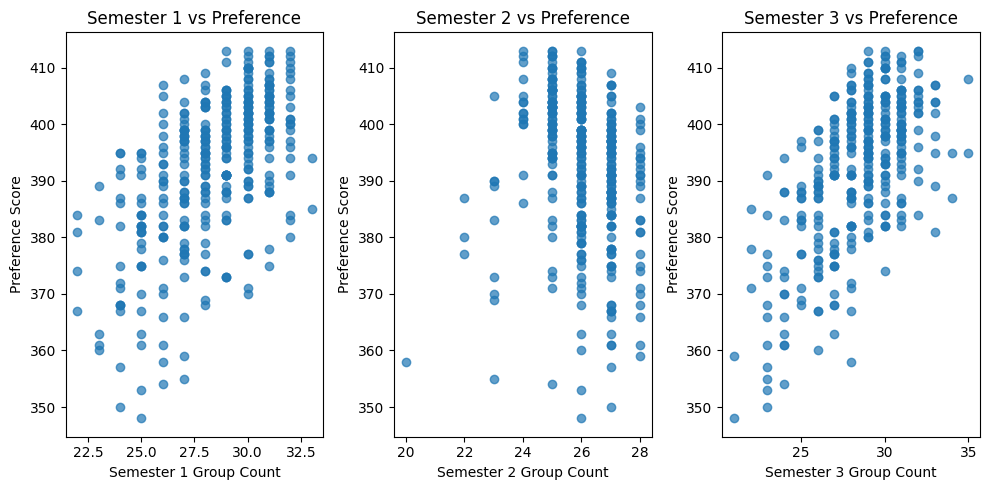

In [ ]:
result_df = pd.DataFrame(semester_group_counts, columns=["Semester 1", "Semester 2", "Semester 3"])
result_df["Total Preference Score"] = objective_values

for sem in ["Semester 1", "Semester 2", "Semester 3"]:
    corr, pval = pearsonr(result_df[sem], result_df["Total Preference Score"])
    print(f"{sem} r = {corr:.4f} (p = {pval:.4f})")
    if pval < 0.05:
        print("\tThere is a significant correlation")
    else:
        print("\tThere is not a significant correlation")

plt.figure(figsize=(10, 5))
for i, sem in enumerate(["Semester 1", "Semester 2", "Semester 3"]):
    plt.subplot(1, 3, i + 1)
    plt.scatter(result_df[sem], result_df["Total Preference Score"], alpha=0.7)
    plt.xlabel(f"{sem} Group Count")
    plt.ylabel("Preference Score")
    plt.title(f"{sem} vs Preference")
plt.tight_layout()
plt.show()

In [ ]:
proportion = greater_count / (simulations-infeasible_count)

print(f"Simulation time：{simulations}")
print(f"{greater_count} times greater than {baseline_score}")
print(f"Infeasible count：{infeasible_count}")
print(f"Portion：{proportion:.2%}")

Simulation time：1000
160 times greater than 396
Infeasible count：645
Portion：45.07%
